# **Sesión práctica 1: Definición de la base de datos y visualización básica**

## **Preparación de la fuente de datos y librerías**

In [2]:
# ============================================
# Dataset: EM-DAT 2025 (desastres/emergencias)
# ============================================

# --- Librerías base ---
import os
from pathlib import Path
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# (Opcional) Tema visual homogéneo para gráficos posteriores
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True

# (Opcional) Configs de pandas para una mejor visualización
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 30)

# --- Instalación ligera para descarga desde Google Drive ---
# gdown maneja bien los enlaces de Drive (incluso archivos grandes)
!pip -q install gdown

import gdown

# ==========================
# 1) Parámetros de entrada
# ==========================
emdat_URL = "https://drive.google.com/file/d/1ZnYIbc52glyzODCILYQLARusE322fP45/view?usp=sharing"  # tu enlace
DATA_DIR = Path("/content/data/public_emdat"); DATA_DIR.mkdir(parents=True, exist_ok=True)
CSV_PATH = DATA_DIR / "public_emdat.csv"

# ==========================
# 2) Descarga
# ==========================
if not CSV_PATH.exists():
    try:
        print(f"Descargando IDMC Displacement → {CSV_PATH} ...")
        out = gdown.download(url=emdat_URL, output=str(CSV_PATH), quiet=False, fuzzy=True)
        assert out is not None and Path(out).exists(), "gdown no pudo descargar el archivo."
        print("✔️ Descarga completada.")
    except Exception as e:
        warnings.warn(
            f"No se pudo descargar desde el enlace proporcionado.\n"
            f"Detalle: {e}\n"
            f"Verifica que el archivo esté en 'Cualquier persona con el enlace (lector)'.\n"
            f"Alternativas: (a) monta tu Drive y lee el CSV directo, (b) sube manualmente el archivo a {CSV_PATH}"
        )

# ==================================================
# 3) Carga del CSV en DataFrame
# ==================================================
# low_memory=False evita inferencias parciales de tipos en archivos grandes.
# encoding='utf-8' suele ser correcto; si notas caracteres raros prueba 'latin-1'.
assert CSV_PATH.exists(), f"No encuentro el archivo en {CSV_PATH}. Revisa el paso de descarga o monta tu Drive."
df = pd.read_csv(CSV_PATH, low_memory=False, encoding="utf-8")

## **1. Introducción**

### **1.1. Breve presentación del problema o pregunta de investigación.** **texto en negrita**

  Se analizará, a escala global, la evolución de los desastres (2000–2024) y su impacto humano con EM-DAT, en dos ejes: (i) frecuencia anual de eventos y (ii) intensidad por evento (Total Deaths y Total Affected).
  Pregunta de investigación: ¿Han aumentado los desastres en número y/o en impacto humano durante 2000–2024, y qué grupo (Natural vs. Tecnológico) concentran la mayor carga total y la mayor severidad por evento?

### **1.2. Contexto: ¿por qué es relevante este problema?**

  Es relevante indagar esta pregunta porque los desastres continúan provocando pérdidas humanas significativas y afectando a millones de personas. Determinar si su frecuencia e impacto están aumentando, y en qué tipos se concentran, permite priorizar prevención y preparación, optimizar recursos limitados y orientar políticas públicas; en definitiva, aporta evidencia para reducir vulnerabilidades y diseñar estrategias de alerta y planificación territorial más efectivas.

### **1.3. Relación entre el problema y la base de datos seleccionada.**

EM-DAT (Public Table, 2000–2024) ofrece registros estandarizados por evento y país con Start Year, Disaster Group/Type y variables de impacto humano (Total Deaths, No. Injured, No. Affected, No. Homeless, Total Affected), lo que permite medir frecuencia anual e intensidad por evento de forma comparable y responder directamente si los desastres aumentan y qué grupos/tipos concentran mayor carga.

## **2. Descripción de la base de datos**

In [3]:
# Vista rápida
display(df.head())

print('-------------------- tamaño del dataset --------------------')
print(f"Archivo local: {CSV_PATH}")

,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,Country,Subregion,Region,Location,Origin,...,Total Deaths,No. Injured,No. Affected,No. Homeless,Total Affected,Reconstruction Costs ('000 US$),"Reconstruction Costs, Adjusted ('000 US$)",Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Admin Units,Entry Date,Last Update
0,1999-9388-DJI,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,DJI,Djibouti,Sub-Saharan Africa,Africa,"Ali Sabieh, Dikhil, Djibouti, Obock, Tadjourah...",NaN,...,NaN,NaN,100000.0,NaN,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,56.446576,"[{""adm1_code"":1093,""adm1_name"":""Ali Sabieh""},{...",2006-03-01,2023-09-25
1,1999-9388-SDN,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,SDN,Sudan,Northern Africa,Africa,"Northern Darfur, Northern Kordofan, Red Sea pr...",NaN,...,NaN,NaN,2000000.0,NaN,2000000.0,NaN,NaN,NaN,NaN,NaN,NaN,54.895152,"[{""adm1_code"":2757,""adm1_name"":""Northern Darfu...",2006-03-08,2023-09-25
2,1999-9388-SOM,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,SOM,Somalia,Sub-Saharan Africa,Africa,"Ceel Barde, Rab Dhuure, Tayeeglow, Xudur distr...",NaN,...,21.0,NaN,1200000.0,NaN,1200000.0,NaN,NaN,NaN,NaN,NaN,NaN,54.895152,"[{""adm1_code"":2691,""adm1_name"":""Bay""},{""adm1_c...",2006-03-08,2023-09-25
3,2000-0001-AGO,No,tec-tra-roa-roa,Technological,Transport,Road,Road,NaN,NaN,AGO,Angola,Sub-Saharan Africa,Africa,Calulo,NaN,...,14.0,11.0,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,54.895152,NaN,2004-10-27,2023-09-25
4,2000-0002-AGO,No,nat-hyd-flo-riv,Natural,Hydrological,Flood,Riverine flood,NaN,NaN,AGO,Angola,Sub-Saharan Africa,Africa,"Dombre Grande village (Baia Farta district, Be...",Heavy rain,...,31.0,NaN,70000.0,NaN,70000.0,NaN,NaN,NaN,NaN,10000.0,18217.0,54.895152,"[{""adm2_code"":4214,""adm2_name"":""Baia Farta""},{...",2005-02-03,2023-09-25


-------------------- tamaño del dataset --------------------
Archivo local: /content/data/public_emdat/public_emdat.csv


In [4]:
# --- Número de registros y variables ---
print(f"Registros (Filas): {df.shape[0]:,}  |  Variables (Columnas): {df.shape[1]:,}")
print('------------------------------------------------------------\n')

Registros (Filas): 16,389  |  Variables (Columnas): 46
------------------------------------------------------------



In [5]:
# --- Tipos de datos ---
print('-------------------- tipos de datos y valores nulos --------------------')
df.info()
print('------------------------------------------------------------\n')

-------------------- tipos de datos y valores nulos --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16389 entries, 0 to 16388
Data columns (total 46 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   DisNo.                                     16389 non-null  object 
 1   Historic                                   16389 non-null  object 
 2   Classification Key                         16389 non-null  object 
 3   Disaster Group                             16389 non-null  object 
 4   Disaster Subgroup                          16389 non-null  object 
 5   Disaster Type                              16389 non-null  object 
 6   Disaster Subtype                           16389 non-null  object 
 7   External IDs                               4081 non-null   object 
 8   Event Name                                 5157 non-null   object 
 9   ISO                  

In [6]:
# --- Clasificación de variables ---
numericas = df.select_dtypes(include=[np.number]).columns.tolist()
categoricas = df.select_dtypes(include=["object"]).columns.tolist()

print('------------------------------------------------------------')
print(" Variables categóricas:")
print("\n".join([f"- {col}" for col in categoricas]))
print('------------------------------------------------------------\n')
print('------------------------------------------------------------')
print("Variables numéricas:")
print("\n".join([f"- {col}" for col in numericas]))
print('------------------------------------------------------------\n')

------------------------------------------------------------
 Variables categóricas:
- DisNo.
- Historic
- Classification Key
- Disaster Group
- Disaster Subgroup
- Disaster Type
- Disaster Subtype
- External IDs
- Event Name
- ISO
- Country
- Subregion
- Region
- Location
- Origin
- Associated Types
- OFDA/BHA Response
- Appeal
- Declaration
- Magnitude Scale
- River Basin
- Admin Units
- Entry Date
- Last Update
------------------------------------------------------------

------------------------------------------------------------
Variables numéricas:
- AID Contribution ('000 US$)
- Magnitude
- Latitude
- Longitude
- Start Year
- Start Month
- Start Day
- End Year
- End Month
- End Day
- Total Deaths
- No. Injured
- No. Affected
- No. Homeless
- Total Affected
- Reconstruction Costs ('000 US$)
- Reconstruction Costs, Adjusted ('000 US$)
- Insured Damage ('000 US$)
- Insured Damage, Adjusted ('000 US$)
- Total Damage ('000 US$)
- Total Damage, Adjusted ('000 US$)
- CPI
-------------

In [7]:
# --- Descripción general ---
print("\nDescripción de variables numéricas:")
display(df.describe().T)


Descripción de variables numéricas:


,count,mean,std,min,25%,50%,75%,max
AID Contribution ('000 US$),489.0,2.855916e+04,2.118956e+05,3.000000,166.000000,765.000000,4.984000e+03,3.518530e+06
Magnitude,3329.0,6.026344e+04,7.466329e+05,-57.000000,16.000000,195.000000,1.955402e+04,4.000000e+07
Latitude,1831.0,1.657615e+01,2.185447e+01,-72.640000,1.152500,18.760000,3.492450e+01,6.793000e+01
Longitude,1831.0,4.205907e+01,7.550920e+01,-172.095000,0.305000,54.260000,1.030565e+02,1.796500e+02
Start Year,16389.0,2.011252e+03,7.511090e+00,2000.000000,2005.000000,2010.000000,2.018000e+03,2.025000e+03
Start Month,16315.0,6.457309e+00,3.399776e+00,1.000000,4.000000,7.000000,9.000000e+00,1.200000e+01
Start Day,14812.0,1.536079e+01,8.962197e+00,1.000000,8.000000,15.000000,2.300000e+01,3.100000e+01
End Year,16389.0,2.011284e+03,7.514150e+00,2000.000000,2005.000000,2011.000000,2.018000e+03,2.025000e+03
End Month,16221.0,6.586339e+00,3.376519e+00,1.000000,4.000000,7.000000,9.000000e+00,1.200000e+01
End Day,14892.0,1.582051e+01,8.887689e+00,1.000000,8.000000,16.000000,2.400000e+01,3.100000e+01


## **3. Análisis inicial de las variables**

In [8]:
# --- Faltantes por variable ---
na_cnt = df.isna().sum()
na_pct = (na_cnt / len(df) * 100).round(2)
faltantes = (pd.DataFrame({"faltantes": na_cnt, "faltantes_%": na_pct})
             .sort_values(["faltantes_%","faltantes"], ascending=False))
mask = (faltantes["faltantes"] > 0) & (faltantes["faltantes_%"] > 0)
print("=== Variables con más faltantes ===")
display(faltantes[mask])

=== Variables con más faltantes ===


,faltantes,faltantes_%
Reconstruction Costs ('000 US$),16356,99.80
"Reconstruction Costs, Adjusted ('000 US$)",16356,99.80
AID Contribution ('000 US$),15900,97.02
"Insured Damage, Adjusted ('000 US$)",15676,95.65
Insured Damage ('000 US$),15669,95.61
River Basin,15063,91.91
No. Homeless,15049,91.82
Latitude,14558,88.83
Longitude,14558,88.83
"Total Damage, Adjusted ('000 US$)",13157,80.28


In [9]:
# --- Conteo de valores únicos por variable ---
print("\nConteo de valores únicos por variable:")
print(df.nunique().sort_values(ascending=False))


Conteo de valores únicos por variable:
DisNo.                                       16389
Location                                     14058
Admin Units                                   6902
Total Affected                                4398
No. Affected                                  3231
External IDs                                  3071
Entry Date                                    2607
Total Damage, Adjusted ('000 US$)             2342
Event Name                                    2175
Latitude                                      1626
Longitude                                     1623
Magnitude                                     1609
River Basin                                   1258
Total Damage ('000 US$)                       1075
Origin                                         826
No. Injured                                    697
No. Homeless                                   586
Insured Damage, Adjusted ('000 US$)            581
Total Deaths                              

In [10]:
# --- Variables mas importantes en el dataset EM-DAT ---
# 1) Candidatas (se prioriza impacto humano y clasificación)
candidatas = [
    # Tiempo / ID / Locación
    "Start Year", "DisNo.", "ISO", "Country", "Region",
    # Clasificación
    "Disaster Group", "Disaster Type", "Disaster Subgroup",
    # Impacto humano (alta cobertura relativa)
    "Total Deaths", "Total Affected",
    # Opcionales si faltantes <= 50%
    "No. Injured", "No. Affected", "No. Homeless",
]

# 2) Mantener solo columnas presentes en el df
cols_presentes = [c for c in candidatas if c in df.columns]

# 3) Filtrar por % faltantes (umbral configurable)
umbral_pct_faltantes = 55.0  # mantén variables con <= 55% faltantes
na_pct = (df[cols_presentes].isna().sum() / len(df) * 100)
variables_clave = [c for c in cols_presentes if na_pct[c] <= umbral_pct_faltantes]

print("Variables clave seleccionadas (<= 55% faltantes):")
for c in variables_clave:
    print(f"- {c}  (faltantes: {na_pct[c]:.1f}%)")
print('------------------------------------------------------------\n')

# 4) Vista rápida
print("\nVista rápida de variables clave:")
print(df[variables_clave].head())
print('------------------------------------------------------------\n')

# 5) Estadísticas descriptivas de variables clave
num_cols = [c for c in ["Start Year", "Total Deaths", "Total Affected",
                        "No. Injured", "No. Affected", "No. Homeless"]
            if c in variables_clave]
cat_cols = [c for c in variables_clave if c not in num_cols]

print('\n------------------------------------------------------------')
print("\nEstadísticas descriptivas (numéricas):")
print('------------------------------------------------------------')
print(df[num_cols].describe().T if num_cols else "— No hay columnas numéricas seleccionadas —")

print('\n------------------------------------------------------------')
print("\nEstadísticas descriptivas (categóricas):")
print('------------------------------------------------------------')
print(df[cat_cols].describe(include='object').T if cat_cols else "— No hay columnas categóricas seleccionadas —")

Variables clave seleccionadas (<= 55% faltantes):
- Start Year  (faltantes: 0.0%)
- DisNo.  (faltantes: 0.0%)
- ISO  (faltantes: 0.0%)
- Country  (faltantes: 0.0%)
- Region  (faltantes: 0.0%)
- Disaster Group  (faltantes: 0.0%)
- Disaster Type  (faltantes: 0.0%)
- Disaster Subgroup  (faltantes: 0.0%)
- Total Deaths  (faltantes: 19.5%)
- Total Affected  (faltantes: 25.2%)
- No. Affected  (faltantes: 53.5%)
------------------------------------------------------------


Vista rápida de variables clave:
   Start Year         DisNo.  ISO   Country  Region Disaster Group Disaster Type Disaster Subgroup  Total Deaths  \
0        2001  1999-9388-DJI  DJI  Djibouti  Africa        Natural       Drought    Climatological           NaN   
1        2000  1999-9388-SDN  SDN     Sudan  Africa        Natural       Drought    Climatological           NaN   
2        2000  1999-9388-SOM  SOM   Somalia  Africa        Natural       Drought    Climatological          21.0   
3        2000  2000-0001-AGO  A

## **4. Visualizaciones exploratorias básicas**

In [68]:
# Columnas de EM-DAT
COL_YEAR  = "Start Year"
COL_GROUP = "Disaster Group"
COL_TYPE  = "Disaster Type"
COL_DEAD  = "Total Deaths"
COL_TAFF  = "Total Affected"
COL_REGION    = "Region"
COL_SUBREGION = "Subregion"

# Recorte opcional del periodo de estudio
dfw = df.copy()
dfw = dfw[dfw[COL_YEAR].between(2000, 2024)]

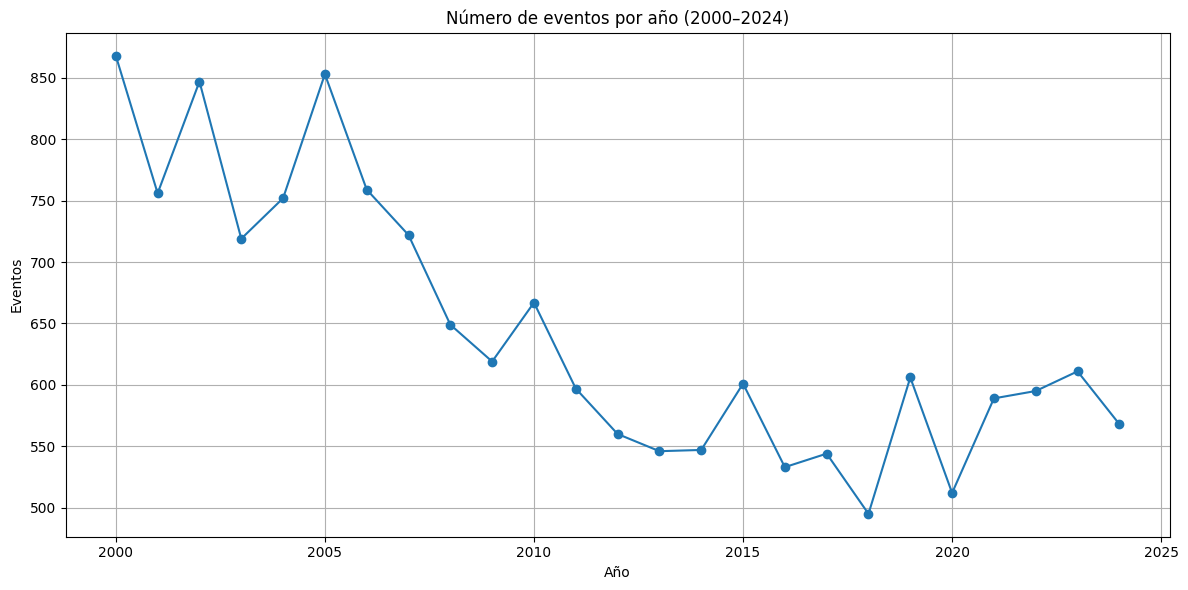

In [50]:
# 1) Frecuencia de eventos por año
# Ver si crece la frecuencia

events_per_year = dfw.groupby(COL_YEAR).size()
plt.figure()
events_per_year.plot(kind="line", marker="o")
plt.title("Número de eventos por año (2000–2024)")
plt.xlabel("Año"); plt.ylabel("Eventos")
plt.tight_layout(); plt.show()

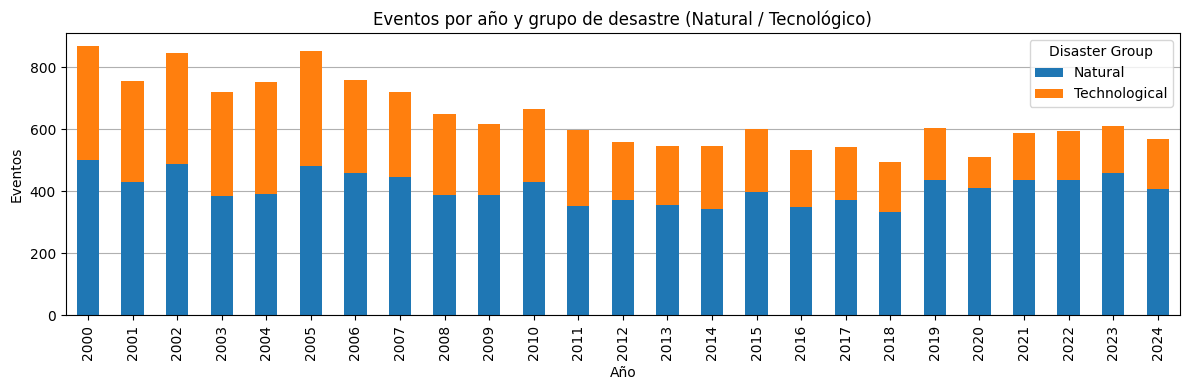

In [51]:
# 2) Barras apiladas: Frecuencia por año y grupo de desastre
# Ver si crece la frecuencia y cómo se reparte entre Natural/Tecnológico.

if COL_GROUP in dfw.columns:
    counts_yg = dfw.groupby([COL_YEAR, COL_GROUP]).size().unstack(fill_value=0)
    counts_yg.plot(kind="bar", stacked=True, figsize=(12,4))
    plt.title("Eventos por año y grupo de desastre (Natural / Tecnológico)")
    plt.xlabel("Año"); plt.ylabel("Eventos")
    plt.grid(False, axis='x')
    plt.gca().set_axisbelow(True)
    plt.tight_layout(); plt.show()

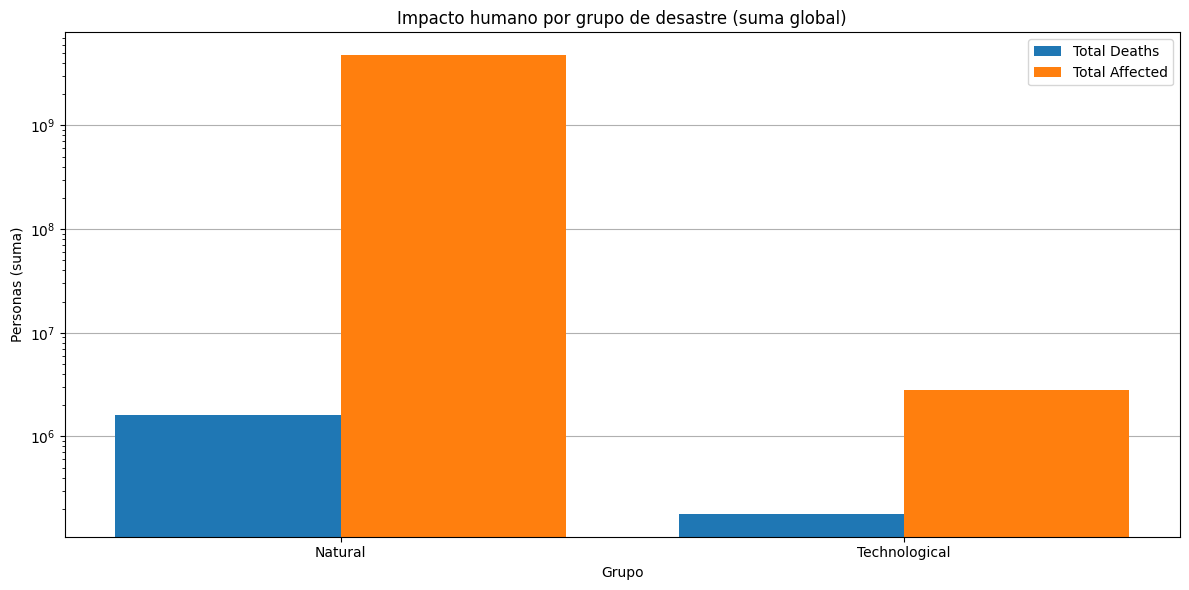

In [52]:
# 3) Barras comparativas: Total Deaths vs Total Affected por grupo
# Comparar el impacto total (muertes vs afectados) por grupo.

if {COL_GROUP, COL_DEAD, COL_TAFF}.issubset(dfw.columns):
    agg = dfw.groupby(COL_GROUP)[[COL_DEAD, COL_TAFF]].sum(min_count=1).fillna(0)
    grupos = agg.index.tolist()
    x = np.arange(len(grupos)); w = 0.4

    fig, ax = plt.subplots()
    b1 = ax.bar(x - w/2, agg[COL_DEAD].values, width=w, label="Total Deaths")
    b2 = ax.bar(x + w/2, agg[COL_TAFF].values, width=w, label="Total Affected")
    ax.set_xticks(x); ax.set_xticklabels(grupos)
    ax.set_title("Impacto humano por grupo de desastre (suma global)")
    ax.set_xlabel("Grupo"); ax.set_ylabel("Personas (suma)")

    ax.set_yscale("log")
    ax.legend()
    ax.grid(False, axis='x')
    ax.set_axisbelow(True)
    plt.tight_layout(); plt.show()

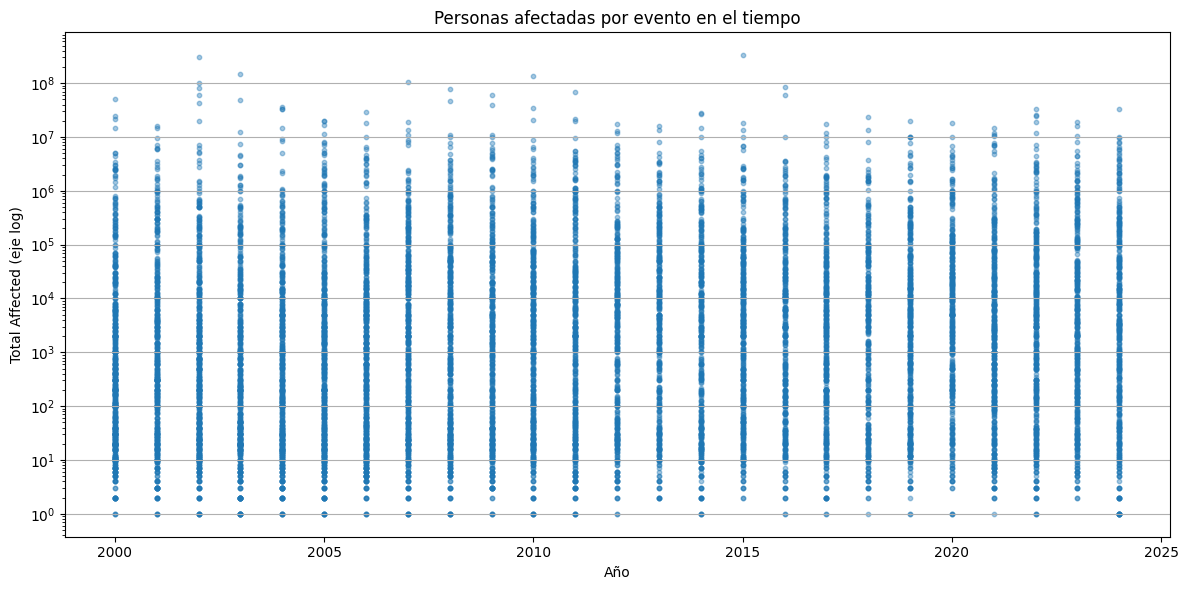

In [53]:
# 4) Dispersión: Año vs Total Affected
# Ver si las personas afectadas por evento cambia con el tiempo.

def scatter_year_y(y, year_col, title, ylabel, use_log=False):
    t = dfw[[year_col, y]].dropna()
    plt.figure()
    plt.scatter(t[year_col], t[y], s=10, alpha=0.4)
    if use_log:
        plt.yscale("log")
        ylabel += " (eje log)"
    plt.title(title); plt.xlabel("Año"); plt.ylabel(ylabel)
    plt.grid(False, axis='x')
    plt.tight_layout(); plt.show()

if {COL_YEAR, COL_TAFF}.issubset(dfw.columns):
    scatter_year_y(COL_TAFF, COL_YEAR, "Personas afectadas por evento en el tiempo", "Total Affected", use_log=True)

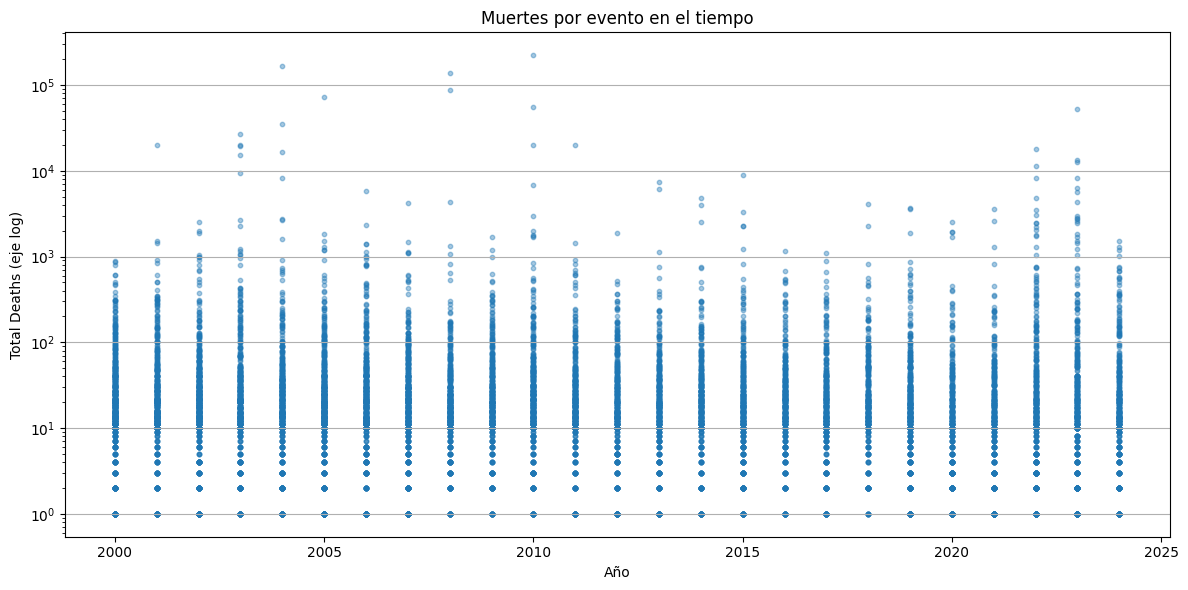

In [54]:
# 5) Dispersión: Año vs Total Deaths
# Ver si las muertes por evento cambia con el tiempo.

if {COL_YEAR, COL_DEAD}.issubset(dfw.columns):
    scatter_year_y(COL_DEAD, COL_YEAR, "Muertes por evento en el tiempo", "Total Deaths", use_log=True)

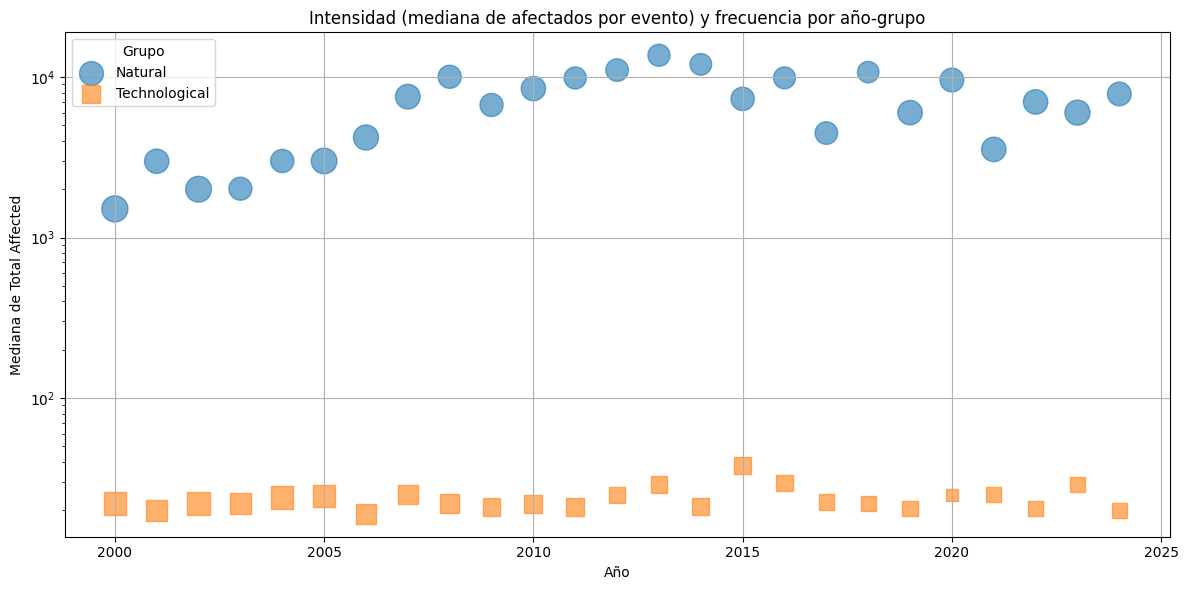

In [59]:
# 6) Burbuja: intensidad por año y grupo de desastre
# Ver cómo cambian la severidad por evento a lo largo del tiempo y por grupo de desastre.

if {COL_YEAR, COL_GROUP, COL_TAFF}.issubset(dfw.columns):
    g = (dfw.groupby([COL_YEAR, COL_GROUP])
            .agg(events=(COL_TAFF,'size'),
                 med_aff=(COL_TAFF,'median'))
            .reset_index())
    plt.figure()
    for grp, mark in [(g[COL_GROUP].unique()[0], "o")] + [(x, "s") for x in g[COL_GROUP].unique()[1:]]:
        sub = g[g[COL_GROUP]==grp]
        plt.scatter(sub[COL_YEAR], sub["med_aff"], s=5 + sub["events"]*0.7,
                    alpha=0.6, marker=mark, label=str(grp))

    plt.yscale("log")
    plt.title("Intensidad (mediana de afectados por evento) y frecuencia por año-grupo")
    plt.xlabel("Año"); plt.ylabel("Mediana de Total Affected")
    plt.legend(title="Grupo")
    plt.tight_layout(); plt.show()

<Figure size 1200x600 with 0 Axes>

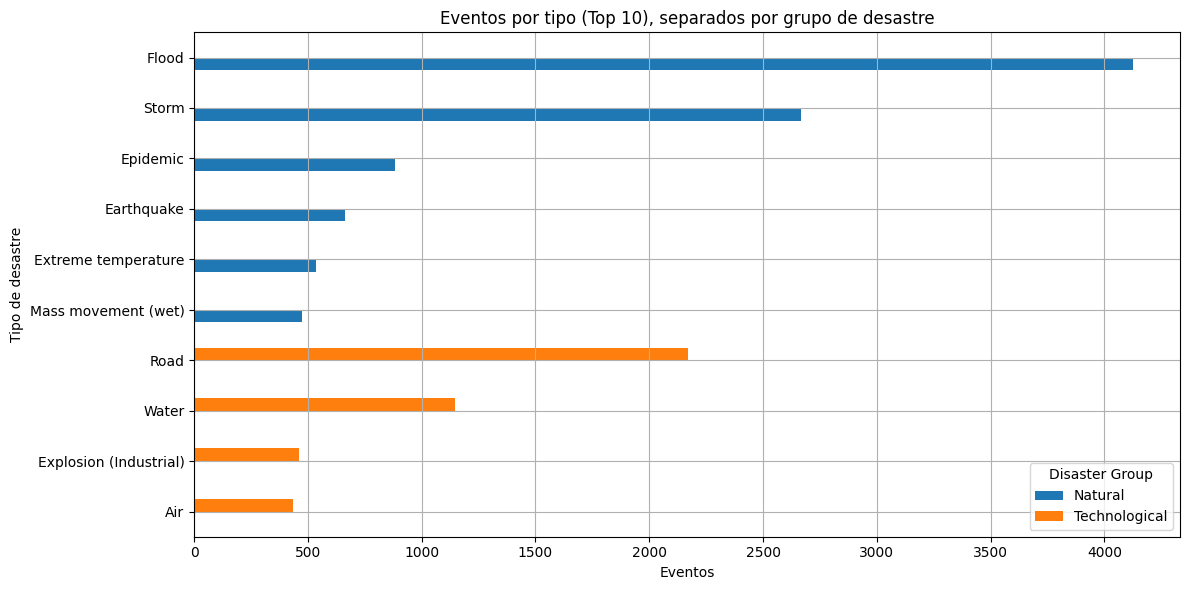

In [55]:
# 7) Barras: eventos por tipo dentro de cada grupo de desastre (Top 10)
# Identificar los tipos de desastre con mayor numero de eventos.

if COL_GROUP in dfw.columns and COL_TYPE in dfw.columns:
    # Conteo por tipo (global) + corte top-10
    top_types = dfw[COL_TYPE].value_counts().head(10).index
    aux = dfw[dfw[COL_TYPE].isin(top_types)]
    ct = aux.groupby([COL_TYPE, COL_GROUP]).size().unstack(fill_value=0)
    ct = ct.sort_values(by=ct.columns.tolist(), ascending=True)  # ordenar por totales
    plt.figure()
    ct.plot(kind="barh", stacked=False)
    plt.title("Eventos por tipo (Top 10), separados por grupo de desastre")
    plt.xlabel("Eventos")
    plt.ylabel("Tipo de desastre")
    plt.tight_layout()
    plt.show()

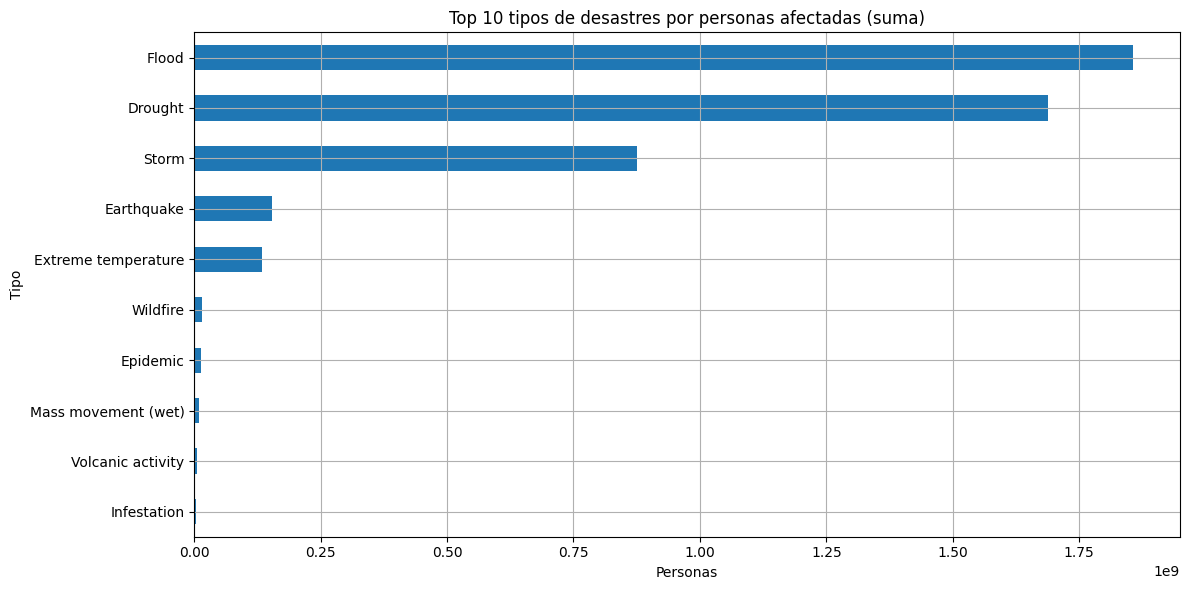

In [57]:
# 8) Top 10 tipos de desastres por personas afectadas.
# Identificar los tipos de desastre con mayor impacto humano.

if {COL_TYPE, COL_TAFF}.issubset(dfw.columns):
    top_aff = (dfw.groupby(COL_TYPE)[COL_TAFF].sum(min_count=1)
                 .sort_values(ascending=False).head(10))
    top_aff.sort_values().plot(kind="barh")
    plt.title("Top 10 tipos de desastres por personas afectadas (suma)"); plt.xlabel("Personas"); plt.ylabel("Tipo")
    plt.tight_layout(); plt.show()

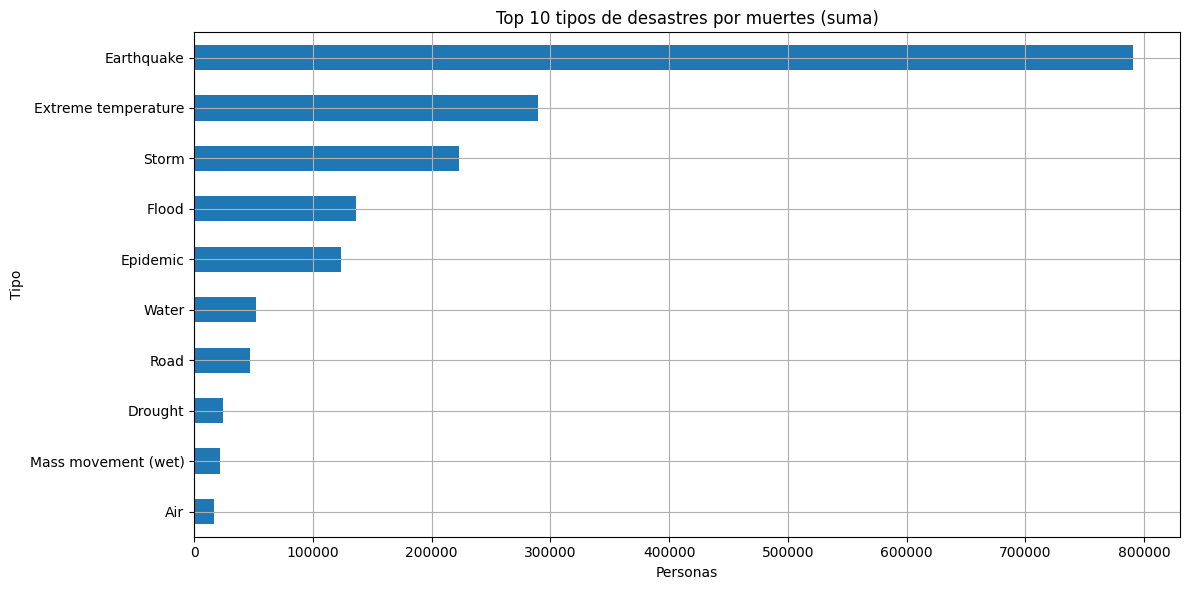

In [58]:
# 8) Top 10 tipos de desastres por muertes.
# Identificar los tipos de desastre con mayor numero de muertes.
if {COL_TYPE, COL_DEAD}.issubset(dfw.columns):
    top_dead = (dfw.groupby(COL_TYPE)[COL_DEAD].sum(min_count=1)
                 .sort_values(ascending=False).head(10))
    top_dead.sort_values().plot(kind="barh")
    plt.title("Top 10 tipos de desastres por muertes (suma)"); plt.xlabel("Personas"); plt.ylabel("Tipo")
    plt.tight_layout(); plt.show()

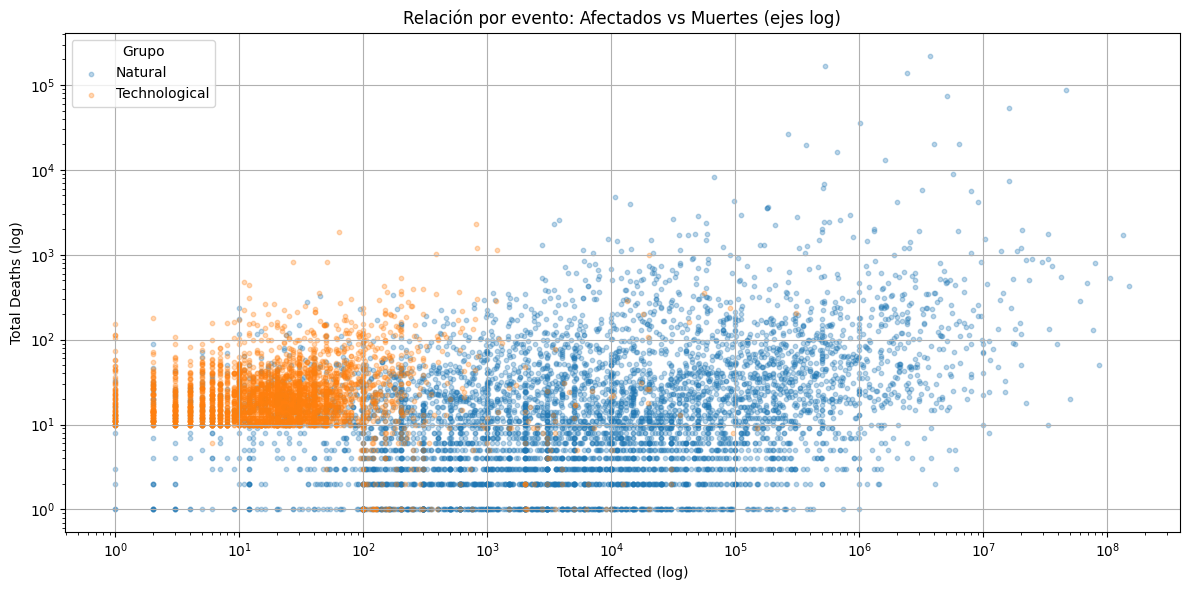

In [66]:
# 9) Dispersión por evento: Total Affected vs Total Deaths.
# Ver si a mayor número de personas afectadas suelen registrarse más muertes.

t = dfw[[COL_TAFF, COL_DEAD, COL_GROUP]].dropna()

# Vista log–log
tp = t[(t[COL_TAFF] > 0) & (t[COL_DEAD] > 0)].copy()
plt.figure()
for grp in tp[COL_GROUP].dropna().unique():
    sub = tp[tp[COL_GROUP] == grp]
    plt.scatter(sub[COL_TAFF], sub[COL_DEAD], s=10, alpha=0.3, label=str(grp))
plt.xscale("log"); plt.yscale("log")
plt.title("Relación por evento: Afectados vs Muertes (ejes log)")
plt.xlabel("Total Affected (log)"); plt.ylabel("Total Deaths (log)")
plt.legend(title="Grupo")
plt.tight_layout(); plt.show()

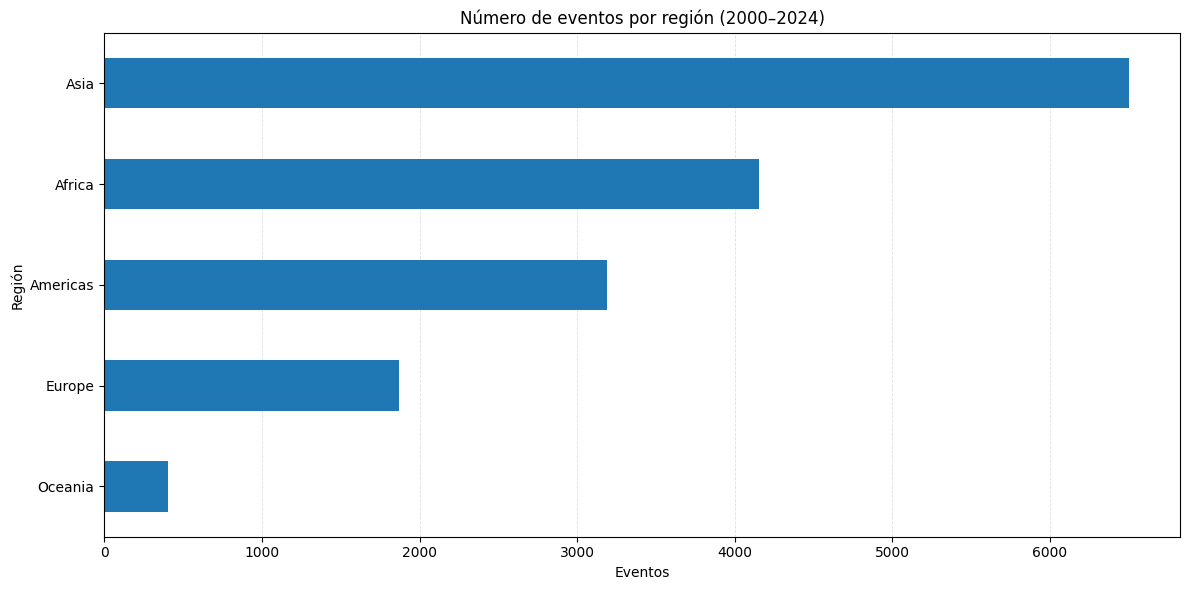

In [82]:
# Conteo de eventos por región.

events_region = dfw.groupby(COL_REGION).size().sort_values()
plt.figure()
events_region.plot(kind="barh")
plt.title("Número de eventos por región (2000–2024)")
plt.xlabel("Eventos"); plt.ylabel("Región")
plt.grid(True, axis='x', linestyle='--', linewidth=0.6, alpha=0.4); plt.grid(False, axis='y')
plt.gca().set_axisbelow(True)
plt.tight_layout(); plt.show()

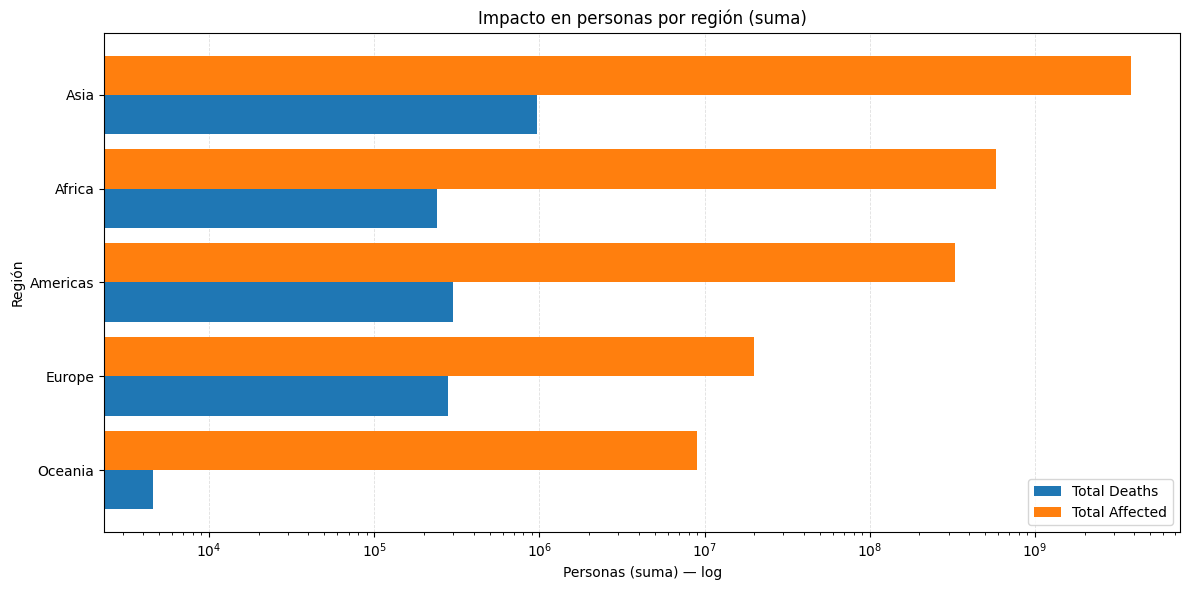

In [80]:
# Impacto en personas por región (comparativa)

agg = dfw.groupby(COL_REGION)[[COL_DEAD, COL_TAFF]].sum(min_count=1).fillna(0)
# ordenar por afectados para lectura
agg = agg.loc[agg[COL_TAFF].sort_values().index]
y = np.arange(len(agg)); h = 0.42

plt.figure()
plt.barh(y - h/2, agg[COL_DEAD].values, height=h, label="Total Deaths")
plt.barh(y + h/2, agg[COL_TAFF].values, height=h, label="Total Affected")
plt.yticks(y, agg.index)
plt.title("Impacto en personas por región (suma)")
plt.xlabel("Personas (suma) — log")
plt.ylabel("Región")
plt.xscale("log")  # para que se vean muertes y afectados en la misma figura
plt.legend()
plt.grid(True, axis='x', linestyle='--', linewidth=0.6, alpha=0.4); plt.grid(False, axis='y')
plt.gca().set_axisbelow(True)
plt.tight_layout(); plt.show()

<Figure size 1200x600 with 0 Axes>

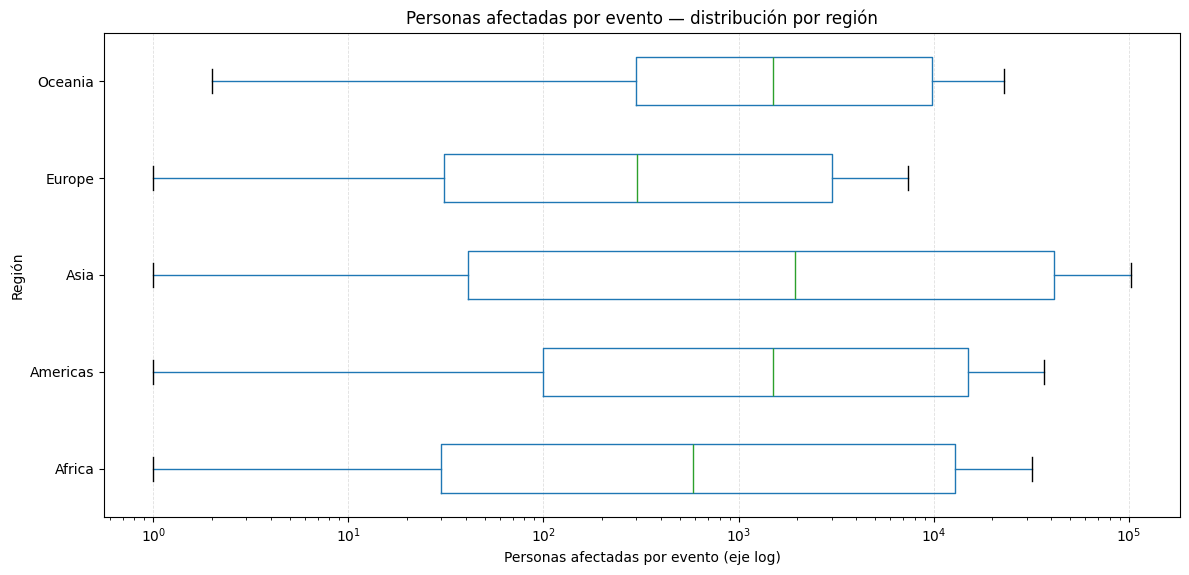

In [72]:
# Boxplot: Afectados por evento vs Regiones.

plt.figure()
dfw.boxplot(column=COL_TAFF, by=COL_REGION, vert=False, showfliers=False)
plt.title("Personas afectadas por evento — distribución por región"); plt.suptitle("")
plt.xlabel("Personas afectadas por evento (eje log)"); plt.ylabel("Región")
plt.xscale("log")  # solo cambia la escala del eje
plt.grid(True, axis='x', linestyle='--', linewidth=0.6, alpha=0.4); plt.grid(False, axis='y')
plt.gca().set_axisbelow(True)
plt.tight_layout(); plt.show()

<Figure size 1200x600 with 0 Axes>

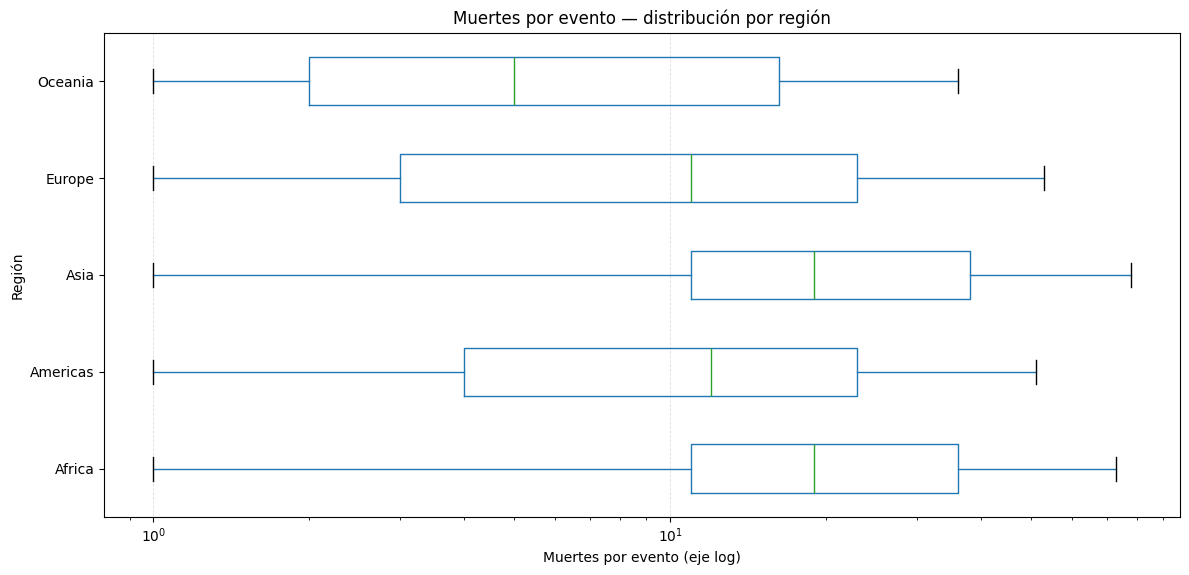

In [74]:
# Boxplot: Muertes por evento vs Regiones.

plt.figure()
dfw.boxplot(column=COL_DEAD, by=COL_REGION, vert=False, showfliers=False)
plt.title("Muertes por evento — distribución por región"); plt.suptitle("")
plt.xlabel("Muertes por evento (eje log)"); plt.ylabel("Región")
plt.xscale("log")
plt.grid(True, axis='x', linestyle='--', linewidth=0.6, alpha=0.4); plt.grid(False, axis='y')
plt.gca().set_axisbelow(True)
plt.tight_layout(); plt.show()

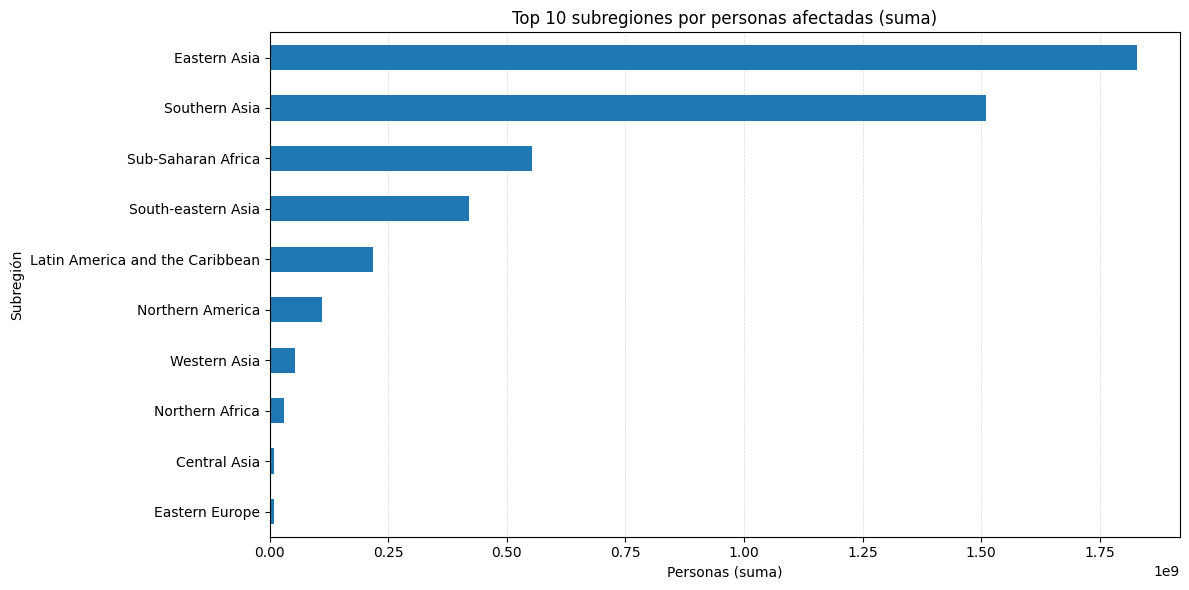

In [79]:
# Top 10 subregiones con mayor numero de afectados.

top_sub_aff = (dfw.groupby(COL_SUBREGION)[COL_TAFF]
                 .sum(min_count=1).sort_values().tail(10))
plt.figure()
top_sub_aff.plot(kind="barh")
plt.title("Top 10 subregiones por personas afectadas (suma)")
plt.xlabel("Personas (suma)"); plt.ylabel("Subregión")
plt.grid(True, axis='x', linestyle='--', linewidth=0.6, alpha=0.4); plt.grid(False, axis='y')
plt.gca().set_axisbelow(True)
plt.tight_layout(); plt.show()

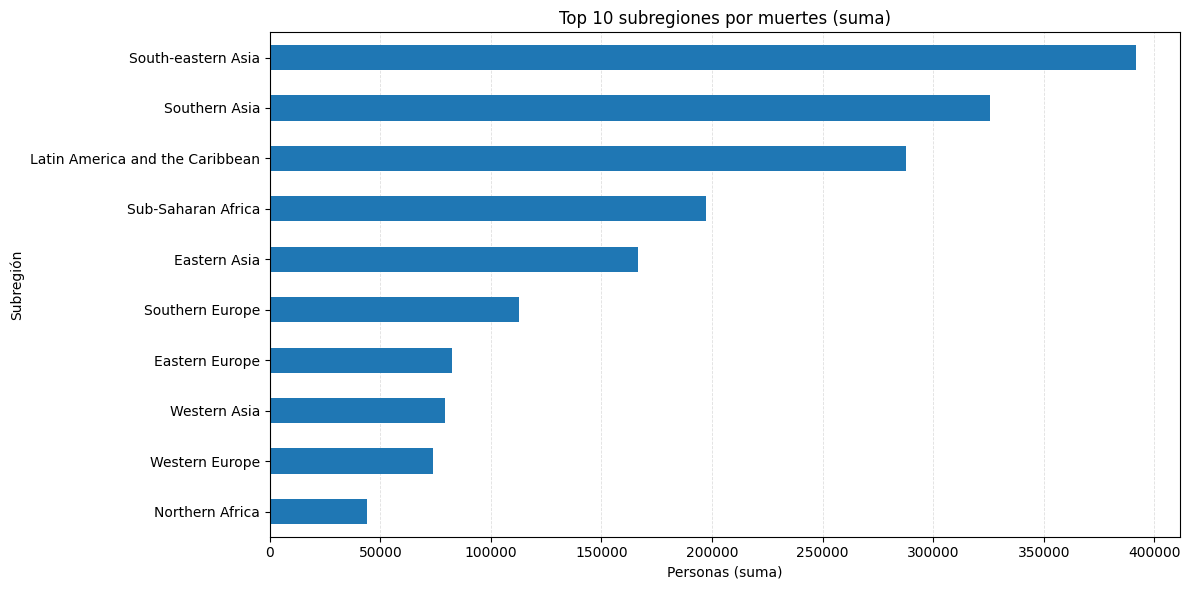

In [78]:
# Top 10 subregiones con mayor numero de muertes.

top_sub_dead = (dfw.groupby(COL_SUBREGION)[COL_DEAD]
                 .sum(min_count=1).sort_values().tail(10))
plt.figure()
top_sub_dead.plot(kind="barh")
plt.title("Top 10 subregiones por muertes (suma)")
plt.xlabel("Personas (suma)"); plt.ylabel("Subregión")
plt.grid(True, axis='x', linestyle='--', linewidth=0.6, alpha=0.4); plt.grid(False, axis='y')
plt.gca().set_axisbelow(True)
plt.tight_layout(); plt.show()

## **5. Interpretaciones iniciales**

### **¿Qué tendencias o patrones básicos se observan?**

* La frecuencia anual es alta a inicios de los 2000, desciende hasta aproximadamente 2014 y luego se estabiliza con leves repuntes; el grupo de desaste Natural domina claramente la cuenta anual.

* En impacto en personas, los desastres naturales son mucho mas mayores que los tecnológicos tanto en muertes como en afectados.

* Por tipos de desastres, las muertes se concentran sobre todo en terremotos y temperaturas extremas; los afectados en inundaciones y sequías.

* Los dispersores muestran colas muy pesadas (pocos eventos extremos) y una asociación positiva (en promedio, a más personas afectadas, más muertes), con mucha dispersión; los desastres tecnológicos se concentran en rangos bajos.

* Asia lidera en número de eventos y en personas afectadas totales; África le sigue en afectados y destaca en muertes totales.

* Las muertes se concentran en South-eastern Asia y Southern Asia; los afectados en Eastern Asia y Southern Asia.

### **¿Qué limitaciones tiene la base de datos?**

* Faltantes altos en variables economicas y humanas no agregadas (por ejemplo, Total Damage ('000 US$), No. Injured, No. Affected, No. Homeless), y en fechas detalladas; ademas, hay una cobertura desigual por año/tipo.

* Valores atípicos muy grandes que pueden sesgar promedios; conviene usar medianas/percentiles y reportar cobertura.

* No todos los países ni todos los años registran los desastres de la misma manera, esto genera diferencias e inconsistencias (faltantes, subregistros) entre países y periodos.

* Sin normalización por cuánta gente está en riesgo (población, urbanización), los números totales de afectados o muertes pueden ser más altos solo porque hay más personas expuestas, no porque el desastre sea más peligroso.

* Si una región tiene mucha más gente, sus totales (afectados/muertes) pueden ser más altos solo por tener más población expuesta. Sin tasas por habitante, no sabemos si fue más peligroso o simplemente había más personas.

### **¿Qué hipótesis iniciales podrían plantearse para análisis posteriores?**

* H1: La cantidad de desastres no aumenta de forma sostenida entre 2000–2024.

* H2: Los desastres naturales presentan mayor impacto en personas (Total Affected y Total Deaths, en suma y por evento) que los tecnológicos.

* H3: Las inundaciones y sequías concentran más personas afectadas, mientras que terremotos y temperaturas extremas concentran más muertes.

* H4: Existe asociación positiva a nivel de evento (a más afectados, más muertes).

* H5: La mediana de personas afectadas y de muertes por evento es mayor en Asia y África que en Europa y Américas.

## **6. Conclusiones**

* No se observa un aumento sostenido de eventos en 2000–2024; tras una caída hasta ~2014, la serie se estabiliza. Los desastres naturales dominan el recuento anual.

* El impacto de los desastres naturales es mayor a los tecnológicos tanto en afectados como en muertes. Por tipo de desastre, inundaciones y sequías concentran la mayor cantidad de afectados, mientras que terremotos y temperaturas extremas concentran más muertes.

* Hay asociación positiva por evento (en promedio, a más afectados, más muertes).

* Asia lidera en número de eventos y personas afectadas; África destaca en muertes. A nivel subregional, South-eastern Asia y Southern Asia concentran muertes; Eastern/Southern Asia, afectados.

## **7. Referencias**

### **Fuente de los datos**

* **Dataset:** EM-DAT, CRED / UCLouvain, 2025, Bruselas, Bélgica – www.emdat.be

* **Data Set Repositorio:** [EM-DAT Documentation](https://doc.emdat.be/docs/)

* **Autores:**  Centro de Investigación sobre la Epidemiología de Desastres (CRED).

* **Descripción:** EM-DAT es la base global de desastres del CRED (1988), creada con apoyo inicial de la OMS y hoy respaldada por USAID/BHA. Reúne más de 26 000 eventos desde 1900 a nivel país, con datos sobre ocurrencia e impacto humano y económico. Se compila a partir de múltiples fuentes (ONU, ONG, aseguradoras, institutos y prensa). Su objetivo es apoyar la acción humanitaria, la preparación y la evaluación de vulnerabilidad y riesgo.


### **Referencias**

* Delforge, D., Wathelet, V., Below, R., Lanfredi Sofia, C., Tonnelier, M., van Loenhout, JAF y Speybroeck, N.: EM-DAT: La base de datos de eventos de emergencia, Revista internacional de reducción del riesgo de desastres , 105509, https://doi.org/10.1016/j.ijdrr.2025.105509 , 2025.